<a href="https://colab.research.google.com/github/marcelosena/cs230/blob/master/CS230_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import sys, os, pickle, time

import tensorflow.compat.v2 as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Flatten, Dense, Conv2D, MaxPool2D,
                                GlobalAveragePooling2D, Activation, BatchNormalization,
                                Dropout, GRU, Bidirectional, Reshape, Lambda)
from tensorflow.keras import backend as K
import sys, os, pickle, time

In [0]:
!git clone https://github.com/marcelosena/cs230
!unzip cs230/CS230OCR/ProcessedData/KerasReady0.zip -d cs230/CS230OCR/ProcessedData/
sys.path.append('/content/cs230/CS230OCR/NeuralNet')

Cloning into 'cs230'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 70 (delta 15), reused 58 (delta 11), pack-reused 0
Unpacking objects: 100% (70/70), done.
Archive:  cs230/CS230OCR/ProcessedData/KerasReady0.zip
  inflating: cs230/CS230OCR/ProcessedData/KerasReady0.npy  


In [0]:
path = '/content/cs230/CS230OCR/'
from utils.inputFinland import loadImgsWithLabels, DataGen
from utils.BasicConfig import (BATCH_SIZE, FULLCHARDICT,  INPUTSHAPE, LOGDIR, SAVEDIR)
from utils.Callbacks import VizCallback
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
  logical_gpus = tf.config.experimental.list_logical_devices('GPU')
  print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


Downloading the large keras dataset through google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip 'gdrive/My Drive/CS230/Keras_largeData/KerasReadyFull0.zip' -d cs230/CS230OCR/ProcessedData/

Archive:  gdrive/My Drive/CS230/Keras_largeData/KerasReadyFull0.zip
  inflating: cs230/CS230OCR/ProcessedData/KerasReadyFull0.npy  


CNN-RNN-CTC

In [0]:
BATCH_SIZE = 32
IMGWIDTH = 128
IMGHEIGHT = 64
CHANNELS = 1
INPUTSHAPE =  [IMGWIDTH,IMGHEIGHT,1]
FULLCHARDICT = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'/':10,',':11, '+': 12, '-': 13, ' ': 14}
CHARDICT = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'/':10,',':11, '+': 12, '-': 13,}
INVDICT = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '/', 11: ',', 12: '+', 13: '-'}
DICTLENGTH = len(CHARDICT) + 1 # for the empty string
MAXCHARLENGTH = 6

Preparing Finish Dataset

In [0]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

X, Y_label, Y_len,  N = loadImgsWithLabels(True)
randomOrder = pickle.load(open(path + f'ProcessedData/orderFull.p', 'rb'))
X = X[randomOrder]
Y_label = Y_label[randomOrder]
Y_len = Y_len[randomOrder]

trainID = int(np.ceil(N*0.33))
devID = trainID + int(np.ceil((N - trainID)/2))

X_train = X[:trainID]
Y_label_train = Y_label[:trainID]
Y_len_train = Y_len[:trainID]

X_dev = X[trainID:devID]
Y_label_dev = Y_label[trainID:devID]
Y_len_dev = Y_len[trainID:devID]

X_test = X[devID:]
Y_label_test = Y_label[devID:]
Y_len_test = Y_len[devID:]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_label_train)).batch(BATCH_SIZE)
dev_dataset = tf.data.Dataset.from_tensor_slices((X_dev, Y_label_dev)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_label_test)).batch(BATCH_SIZE)

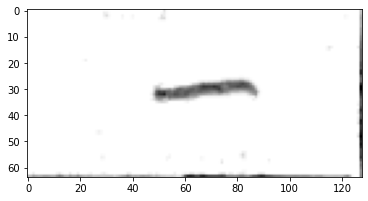

[13. -1. -1. -1. -1. -1.]


In [0]:
from matplotlib import pyplot as plt

plt.imshow(X_test[834,:,:,0].T, cmap='Greys')
plt.show()
print(Y_label_test[834])

# try all other channels being zeros or ones

Model Specification

In [0]:
# Transer Learning portion

INPUTSHAPE_CHAN3 =  [IMGWIDTH,IMGHEIGHT,3]
X_train_CHAN3 = np.repeat(X_train, 3, -1)

# from tensorflow.keras.applications.vgg16 import VGG16
# base_model = keras.applications.ResNet50(
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape= INPUTSHAPE_CHAN3,
    include_top=False)
base_model.trainable = False
base_model.summary()
# print(base_model.get_layer("conv5_block3_out").output_shape)
# inputs = Input(name='the_input', shape=INPUTSHAPE_CHAN3)
# inputs = base_model(inputs, training=False)
# # # converts the output of pre-trained CNN for RGB images to grayscale
# inputs = Lambda(lambda x : x[:,:,:,0])(inputs)
# print(tf.shape(inputs))


80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 64, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 64, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 32, 128)       147584    
______________________________________________________________

In [0]:
## NOTE: SEQUENTIAL MODEL NOT APPROPRIATE FOR RESNET TYPE MODELS

tiling = [1] * 4 
tiling[-1] *= 3

model = keras.Sequential()
model.add(keras.Input(name = "the_input", shape=INPUTSHAPE))
model.add(Lambda(lambda x : keras.backend.tile(x, tiling))
model.add(keras.layers(base_model.layers[0]))
model.add(base_model.layers[1])
model.add(base_model.layers[2])
model.add(base_model.layers[3])
model.add(base_model.layers[4])

SyntaxError: ignored

In [0]:
################################################
#%%
# Layer params:   Filts K  Padding  Name
layer_params = [ [  64, 7, 'same',  'conv1'],
                 [  64, 5, 'same',  'conv2'],
                 [ 128, 3, 'same',  'conv3'],
                 [ 128, 3, 'same',  'conv4'],
                 [ 256, 3, 'same',  'conv5'],
                 [ 256, 3, 'same',  'conv6'],
                 # [ 512, 3, 'same',  'conv7'],
                 # [ 512, 3, 'same',  'conv8'],
                 # [ 1024, 3, 'same',  'conv9'],
                 # [ 1024, 3, 'same',  'conv10'],
                 # [ 1024, 3, 'same',  'conv11'],
                 ]
wherePool = [1,3,5]

# Network parameters
kernel_size = (3, 3)
pool_size = (2,2)
denseSize = 128
rnn_size = 256
act = 'relu'
minibatch_size = BATCH_SIZE

### Transfer-Learned Conv-NN ###
tiling = [1] * 4    # 4 dimensions: B, H, W, C
tiling[-1] *= 3
inputs = Input(name='the_input', shape=INPUTSHAPE)
inner = keras.backend.tile(inputs, tiling)

# inner = base_model(inner)

# # only the first conv-nn part
l1 = base_model.layers[0]
l2 = base_model.layers[1]
l3 = base_model.layers[2]
l4 = base_model.layers[3]
l5 = base_model.layers[4]
l1.set_weights = l1.get_weights()
l2.set_weights = l2.get_weights()
l3.set_weights = l3.get_weights()
l4.set_weights = l4.get_weights()
l5.set_weights = l5.get_weights()

# # Setting layers to non-trainable
retrain = False
l1.trainable = retrain
l2.trainable = retrain
l3.trainable = retrain
l4.trainable = retrain
l5.trainable = retrain
inner = l1(inner)
inner = l2(inner)
inner = l3(inner)
inner = l4(inner)
inner = l5(inner)

# print(len(base_model.layers))
# ### all conv-nn parts
# for ll in range(len(base_model.layers) - 20):
#   if ll != 14 and ll != 17 and ll != 27 and ll != 37 and ll != 45 and ll != 49 and ll != 59 and ll != 69 and ll != 79 and ll != 87 and ll != 91 and ll != 101 and ll != 111:
#     tmp_ll = base_model.layers[ll]
#     tmp_ll.set_weights = base_model.layers[ll].get_weights()
#     tmp_ll.trainable = retrain
#     inner = tmp_ll(inner)

# # converts the grayscale images to 3-channel amenable CNN
# inner = Lambda(lambda x : np.repeat(x,3,-1))(inputs) # this does not work, need to use proper Keras syntax/functions

# # converts the output of pre-trained CNN for RGB images to grayscale
# inner = Lambda(lambda x : x[:,:,:,0])(inputs)

# ### Our Conv-NN ###
# inputs = Input(name='the_input', shape=INPUTSHAPE)
# layer = layer_params[0]
# inner = Conv2D(layer[0], layer[1], strides=(1,1), padding=layer[2], activation=act,
#                      use_bias=False, kernel_initializer="he_normal", name=layer[3] )(inputs)
# inner = BatchNormalization(momentum=0.95, epsilon=1e-05, center=True, scale=True)(inner)

# for i in range(1,len(layer_params)):
#     layer = layer_params[i]
#     inner = Conv2D(layer[0], layer[1], strides=(1,1), padding=layer[2], activation=act,
#                      use_bias=False, kernel_initializer="he_normal", name=layer[3] )(inner)
#     inner = BatchNormalization(momentum=0.95, epsilon=1e-05, center=True, scale=True)(inner)

#     if i in wherePool:
#        inner = MaxPool2D(pool_size=pool_size, strides=(2, 2), padding='same', name=f'pool{i+1}')(inner)

# conv_to_rnn_dims = ( IMGWIDTH// (pool_size[0] ** len(wherePool)) ,
#                     (IMGHEIGHT  // (pool_size[0] ** len(wherePool))) * layer_params[-1][0]
#                    )
# print(conv_to_rnn_dims)

inner = inner
trOutShape = inner.shape
print(trOutShape)
conv_to_rnn_dims_transfer = (trOutShape[1], trOutShape[2]*trOutShape[3])
print(conv_to_rnn_dims_transfer)

inner = Reshape(target_shape=conv_to_rnn_dims_transfer, name='reshape')(inner)
inner = Dense(denseSize, activation=act, name='dense1')(inner)
inner = BatchNormalization(momentum=0.95, epsilon=1e-05, center=True, scale=True)(inner)

# # Two layers of bidirectional GRUs
gru_1 = Bidirectional(GRU(rnn_size, return_sequences=True, recurrent_dropout=0.5, dropout=0.5,
            kernel_initializer='he_normal', name='gru1'), merge_mode='sum')(inner)
gru_2 = Bidirectional(GRU(rnn_size, return_sequences=True, recurrent_dropout=0.5, dropout=0.5,
            kernel_initializer='he_normal', name='gru2'))(gru_1)
y_pred = Dense(DICTLENGTH, kernel_initializer='he_normal', name='densePredict', activation='softmax')(gru_2)

# keras.Model(inputs=inputs, outputs=y_pred).summary()

#%%
labels = Input(name='the_labels', shape=[MAXCHARLENGTH], dtype='float32')
input_length = Input(name='input_length',
                     shape=[1], #IMGWIDTH// (pool_size[0] ** len(wherePool)) - 2
                     dtype='int64')
label_length = Input(name='label_length',
                     shape=[1],
                     dtype='int64')

#CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,),
    name='ctc')([y_pred, labels, input_length, label_length])

sgd = keras.optimizers.SGD(learning_rate=0.02,
          decay=1e-6,
          momentum=0.9,
          nesterov=True)
model = keras.Model(inputs=[inputs, labels, input_length, label_length],
              outputs=loss_out)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd, metrics=["accuracy"])
test_func = K.function([inputs], [y_pred])

# model.summary()

(None, 64, 32, 128)
(64, 4096)


Model Fitting

In [0]:
generatorTrain = DataGen(BATCH_SIZE,  (IMGWIDTH// (pool_size[0] ** len(wherePool))-2),
                    X_train, Y_label_train, Y_len_train,  len(X_train), 0)
generatorVal = DataGen(BATCH_SIZE,  (IMGWIDTH// (pool_size[0] ** len(wherePool))-2),
                    X_dev, Y_label_dev, Y_len_dev,  len(X_dev), 0)
generatorTest = DataGen(BATCH_SIZE,  (IMGWIDTH// (pool_size[0] ** len(wherePool))-2),
                    X_test, Y_label_test, Y_len_test,  len(X_test), 0)

#viz_cb = VizCallback(run_name, test_func, generatorVal.get_batch())
# early_stopping= keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='acc', baseline = 0.95, min_delta = 0.1, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint("bestRunning_model.hdf5",
                                            monitor='loss', verbose=1,
                                            save_best_only=True, mode='auto')

#%%
from tensorflow.keras.callbacks import EarlyStopping
usualCallback = EarlyStopping()
callCheck = [usualCallback, checkpoint]

history = model.fit(generatorTrain.get_batch(), epochs=5,
                       validation_data = generatorVal.get_batch(),
                    validation_steps = len(X_dev)//BATCH_SIZE,
                    steps_per_epoch = 20) #,
                    # callbacks = [usualCallback])
                    #callbacks=[viz_cb, early_stopping, checkpoint],)

Epoch 1/5
20/20 [==============================] - 24s 1s/step - loss: 14.3091 - accuracy: 0.1266 - val_loss: 67.3044 - val_accuracy: 0.0000e+00
Epoch 2/5
20/20 [==============================] - 23s 1s/step - loss: 12.4490 - accuracy: 0.1562 - val_loss: 157.8416 - val_accuracy: 0.0015
Epoch 3/5
20/20 [==============================] - 23s 1s/step - loss: 11.3838 - accuracy: 0.1656 - val_loss: 19.0766 - val_accuracy: 0.1192
Epoch 4/5
20/20 [==============================] - 23s 1s/step - loss: 11.2345 - accuracy: 0.1391 - val_loss: 10.8731 - val_accuracy: 0.1940
Epoch 5/5
20/20 [==============================] - 23s 1s/step - loss: 10.8547 - accuracy: 0.1609 - val_loss: 13.4791 - val_accuracy: 0.1428


In [0]:
# # Test Accuracy
# testFig = X_test[1,:,:,:]
# testLab = Y_label_test[1,:]
# print(X_test.shape)
# print(Y_label_test.shape)
# _, test_acc = model.evaluate(x = X_test, y = Y_label_test, verbose=-1)

(2781, 128, 64, 1)
(2781, 6)


AssertionError: ignored